In [9]:
!pip install GEOparse

import GEOparse
gse = GEOparse.get_GEO("GSE9006", destdir="data/")


22-Jun-2025 20:53:14 DEBUG utils - Directory data/ already exists. Skipping.
DEBUG:GEOparse:Directory data/ already exists. Skipping.
22-Jun-2025 20:53:14 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
22-Jun-2025 20:53:14 INFO GEOparse - Parsing data/GSE9006_family.soft.gz: 
INFO:GEOparse:Parsing data/GSE9006_family.soft.gz: 
22-Jun-2025 20:53:14 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
22-Jun-2025 20:53:14 DEBUG GEOparse - SERIES: GSE9006
DEBUG:GEOparse:SERIES: GSE9006
22-Jun-2025 20:53:14 DEBUG GEOparse - PLATFORM: GPL96
DEBUG:GEOparse:PLATFORM: GPL96
22-Jun-2025 20:53:16 DEBUG GEOparse - PLATFORM: GPL97
DEBUG:GEOparse:PLATFORM: GPL97
22-Jun-2025 20:53:17 DEBUG GEOparse - SAMPLE: GSM228562
DEBUG:GEOparse:SAMPLE: GSM228562
22-Jun-2025 20:53:17 DEBUG GEOparse - SAMPLE: GSM228563
DEBUG:GEOparse:SAMPLE: GSM228563
22-Jun-2025 20:53:17 DEBUG GEOparse - SAMPLE: GSM228564
DEBUG:GEOparse:SAMPLE: GSM

In [10]:
# Expression matrix (samples × genes)
expr = gse.pivot_samples("VALUE")
expr.to_csv("data/gene_expression.csv")

# Sample metadata
meta = gse.phenotype_data
meta.to_csv("data/clinical_metadata.csv")


In [11]:
import pandas as pd

X = pd.read_csv("data/gene_expression.csv", index_col=0)
meta = pd.read_csv("data/clinical_metadata.csv", index_col=0)

# Check where the labels are
print(meta.columns.tolist())
print(meta.head(3))


['title', 'geo_accession', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'taxid_ch1', 'characteristics_ch1.0.Age', 'characteristics_ch1.1.Gender', 'characteristics_ch1.2.Ethnicity', 'characteristics_ch1.3.Race', 'characteristics_ch1.4.Illness', 'characteristics_ch1.5.pH<7.30 at time of diagnosis', 'molecule_ch1', 'extract_protocol_ch1', 'label_ch1', 'label_protocol_ch1', 'hyb_protocol', 'scan_protocol', 'description', 'data_processing', 'platform_id', 'contact_name', 'contact_email', 'contact_institute', 'contact_address', 'contact_city', 'contact_state', 'contact_zip/postal_code', 'contact_country', 'supplementary_file', 'relation', 'series_id', 'data_row_count', 'characteristics_ch1.5.Treatment', 'characteristics_ch1.6.pH<7.30 at time of diagnosis']
                                title geo_accession                 status  \
GSM228562  PBMCs-Healthy-H122_Healthy     GSM228562  Public on Sep 12 2007   
GSM228563  PBMCs-He

In [12]:
# Extract disease status from title field
meta['T2D_status'] = meta['title'].str.contains('T2D|Diabetes', case=False).astype(int)

# Confirm labels
print("Label distribution:\n", meta['T2D_status'].value_counts())


Label distribution:
 T2D_status
1    186
0     48
Name: count, dtype: int64


In [13]:
# Make sure sample IDs align
common_ids = X.columns.intersection(meta.index)

# Subset both to the same samples
X = X[common_ids].T  # Transpose: samples as rows
y = meta.loc[common_ids, 'T2D_status']


In [14]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Label balance:\n", y.value_counts())


X shape: (234, 44760)
y shape: (234,)
Label balance:
 T2D_status
1    186
0     48
Name: count, dtype: int64


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create Random Forest with class_weight='balanced'
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # 💡 key line
)

# Train the model
clf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = clf.predict(X_test_scaled)

# Evaluate performance
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧾 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.79      1.00      0.88        37

    accuracy                           0.79        47
   macro avg       0.39      0.50      0.44        47
weighted avg       0.62      0.79      0.69        47

🧾 Confusion Matrix:
[[ 0 10]
 [ 0 37]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


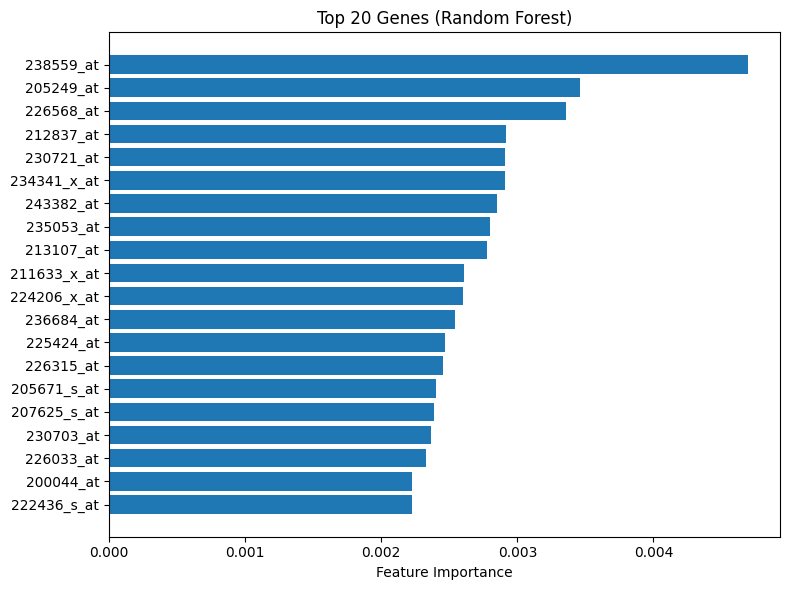

In [17]:
import numpy as np
import matplotlib.pyplot as plt

importances = clf.feature_importances_
top_indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8, 6))
plt.barh(range(20), importances[top_indices], align='center')
plt.yticks(range(20), X.columns[top_indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Genes (Random Forest)")
plt.tight_layout()
plt.show()


In [18]:
from sklearn.feature_selection import SelectFromModel

# Already trained Random Forest classifier (clf)
sfm = SelectFromModel(clf, threshold="median", prefit=True)
X_train_fs = sfm.transform(X_train_scaled)
X_test_fs = sfm.transform(X_test_scaled)


In [19]:
clf_fs = RandomForestClassifier(n_estimators=100, random_state=42)
clf_fs.fit(X_train_fs, y_train)


RandomForestClassifier(random_state=42)

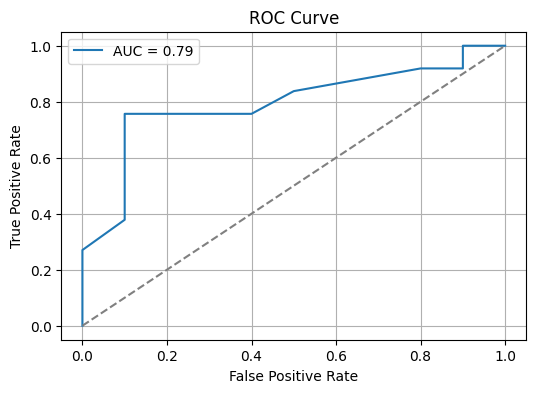

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_proba = clf_fs.predict_proba(X_test_fs)[:, 1]

# Compute ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
pip install shap

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap


In [23]:
# Load gene expression and metadata
X = pd.read_csv("data/gene_expression.csv", index_col=0)
meta = pd.read_csv("data/clinical_metadata.csv", index_col=0)

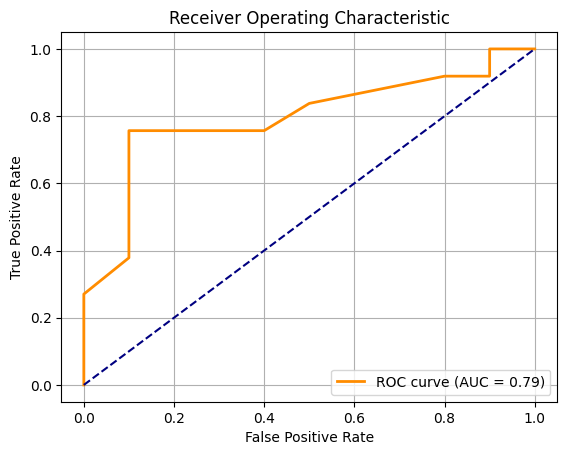

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = clf_fs.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


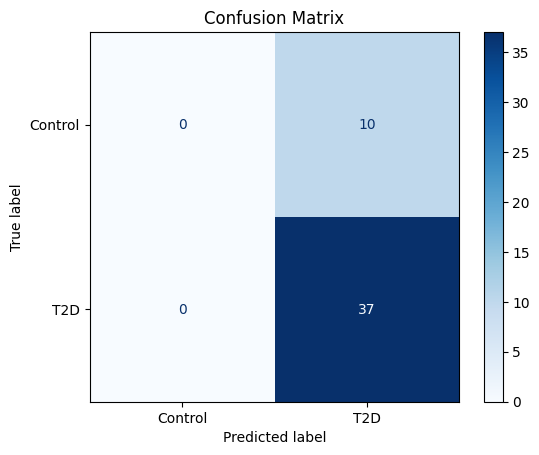

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'T2D'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


Precision: 0.79
Recall:    1.00
F1 Score:  0.88
